# Importing Required Libraries

In [31]:
import os
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

# Importing Data

In [32]:
def load_images_from_folder(base_path):
    datasets = {'healthy': {'images': [], 'labels': []},
                'parkinson': {'images': [], 'labels': []}}
    
    for dataset in ['testing', 'training']:
        dataset_path = os.path.join(base_path, 'spiral', dataset)
        
        for class_label, class_folder in enumerate(['healthy', 'parkinson']):
            class_path = os.path.join(dataset_path, class_folder)
            
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    
                    try:
                        with Image.open(img_path) as img:
                            img = img.convert('RGB')
                            img = img.resize((224, 224))  # Adjust size as needed
                            img_array = np.array(img)
                            datasets[class_folder]['images'].append(img_array)
                            datasets[class_folder]['labels'].append(class_label)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    for dataset in datasets:
        datasets[dataset]['images'] = np.array(datasets[dataset]['images'])
        datasets[dataset]['labels'] = np.array(datasets[dataset]['labels'])
    
    return datasets

# Usage
base_path = 'D:\Projects\Parkinsons_disease\image_model\data'
datasets = load_images_from_folder(base_path)

# Access healthy and parkinson data separately
X_healthy, y_healthy = datasets['healthy']['images'], datasets['healthy']['labels']
X_parkinson, y_parkinson = datasets['parkinson']['images'], datasets['parkinson']['labels']

print(f"Loaded {len(X_healthy)} healthy images and {len(X_parkinson)} parkinson images")
print(f"Image shape: {X_healthy[0].shape}")
print(f"Number of classes: {len(np.unique(np.concatenate([y_healthy, y_parkinson])))}")

Loaded 51 healthy images and 51 parkinson images
Image shape: (224, 224, 3)
Number of classes: 2


In [33]:
df = pd.read_csv('D:/Projects/Parkinsons_disease/image_model/data/parkinsons_disease_data.csv')

# Data Cleaning

In [34]:
df=df.drop(['PatientID','DoctorInCharge'],axis=1)

In [35]:
dff = df.drop(['SystolicBP', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides','DiastolicBP', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking',
       'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
        'TraumaticBrainInjury', 'Hypertension',
       'Diabetes', 'Stroke','AlcoholConsumption','Constipation',
       'CholesterolTriglycerides',],axis=1)
XX = dff.drop('Diagnosis',axis=1)
y = dff['Diagnosis']

In [36]:
from sklearn.model_selection import train_test_split
X_train_clinical,X_test_clinical,y_train_clinical,y_test_clinical = train_test_split(XX,y,random_state=0,test_size=0.2)

# Model 1: XGBoost

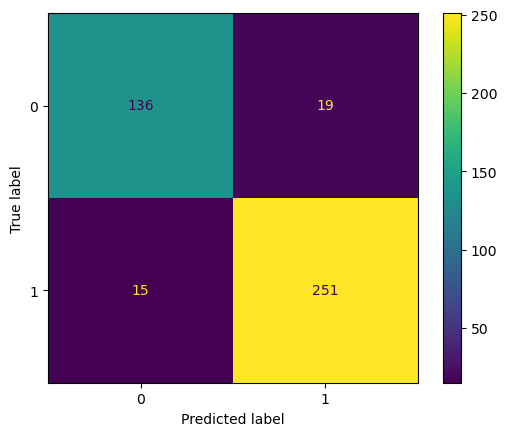

In [37]:
dtrain = xgb.DMatrix(X_train_clinical, label=y_train_clinical)
dtest = xgb.DMatrix(X_test_clinical, label=y_test_clinical)

params = {
    'objective': 'binary:logistic',  # Specify binary classification
    'max_depth': 6,  # Maximum depth of a tree
    'eta': 0.2,  # Learning rate
    'eval_metric': 'logloss'  # Evaluation metric
}

# Train the model
num_rounds = 250
bst = xgb.train(params=params,dtrain=dtrain, num_boost_round=num_rounds)
preds = bst.predict(dtest)
predictions = [1 if p > 0.5 else 0 for p in preds]
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_clinical,predictions))
disp.plot()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

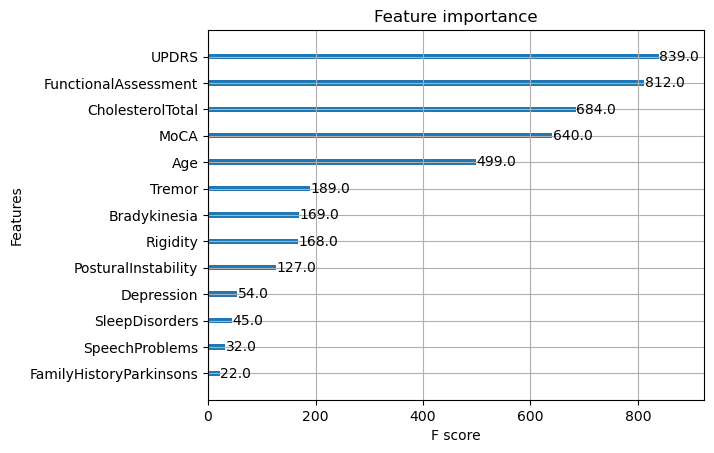

In [38]:
xgb.plot_importance(bst)

In [39]:
seed = np.random.randint(0,51,45,)

In [40]:
seed

array([43,  6,  8, 14, 32, 50,  0, 12,  5, 43, 40, 30, 14, 27, 22, 11, 21,
        5, 24, 32, 43, 13, 29, 39, 26,  3, 35, 15, 20, 11, 35, 24, 46, 11,
       11, 40, 14, 25,  0, 31, 17, 33, 10, 22, 14])

In [41]:
X_test_image_df = []
Y_test_image_labels = [0]*45 + [1]*45

for element in seed:
    X_test_image_df.append(X_healthy[element])
for element in seed:
    X_test_image_df.append(X_parkinson[element])

In [42]:
X_test_image_df = np.array(X_test_image_df)

# Model 2: ResNet152 (PreTrained) 

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf


def classify_images(array_of_images):
    embeddings_A = np.load('D:\\Projects\\Parkinsons_disease\\image_model\\embeddings\\healthy_embeddings.npy')
    embeddings_B = np.load('D:\\Projects\\Parkinsons_disease\\image_model\\embeddings\\parkinson_embeddings.npy')
    parkinson_embedding_model = tf.keras.models.load_model('D:\\Projects\\Parkinsons_disease\\image_model\\data\\parkinson_embedding_model.h5')
    healthy_embedding_model = tf.keras.models.load_model('D:\\Projects\\Parkinsons_disease\\image_model\\data\\healthy_embedding_model.h5')
    class_confidence = []
    for i in range(array_of_images.shape[0]):
        embedding_A = healthy_embedding_model.predict(np.expand_dims(array_of_images[i], axis=0))
        embedding_B = parkinson_embedding_model.predict(np.expand_dims(array_of_images[i], axis=0))
    
        # Compute similarity scores
        sim_A = np.max(cosine_similarity(embedding_A, embeddings_A))
        sim_B = np.max(cosine_similarity(embedding_B, embeddings_B))
        if sim_A > sim_B:
            class_confidence.append(abs(1-((sim_A+1)/2)))
        else:
            class_confidence.append(((sim_B+1)/2))
    return class_confidence

In [44]:
image_confidence = classify_images(X_test_image_df)

1/1 [==============================] - 0s 197ms/step


In [45]:
image_confidence

[5.960464477539063e-08,
 3.5762786865234375e-07,
 5.960464477539063e-08,
 2.9802322387695312e-08,
 0.08662673830986023,
 2.980232238769531e-07,
 1.1920928955078125e-07,
 0.047133684158325195,
 1.7881393432617188e-07,
 5.960464477539063e-08,
 2.682209014892578e-07,
 1.1920928955078125e-07,
 2.9802322387695312e-08,
 0.05705663561820984,
 0.04715079069137573,
 0.03345552086830139,
 2.384185791015625e-07,
 1.7881393432617188e-07,
 5.960464477539063e-08,
 0.08662673830986023,
 5.960464477539063e-08,
 6.556510925292969e-07,
 0.048642873764038086,
 0.040411949157714844,
 0.07269370555877686,
 8.940696716308594e-08,
 0.07404455542564392,
 3.5762786865234375e-07,
 5.960464477539063e-08,
 0.03345552086830139,
 0.07404455542564392,
 5.960464477539063e-08,
 3.5762786865234375e-07,
 0.03345552086830139,
 0.03345552086830139,
 2.682209014892578e-07,
 2.9802322387695312e-08,
 2.980232238769531e-07,
 1.1920928955078125e-07,
 4.470348358154297e-07,
 0.09845471382141113,
 0.030162781476974487,
 0.097155

# Creating Dataset with both Models' confidence

In [46]:
np.unique(y_test_clinical,return_counts=True)

(array([0, 1], dtype=int64), array([155, 266], dtype=int64))

In [47]:
np.where(y_test_clinical==0)[0]

array([  3,   5,   7,   8,  10,  12,  14,  18,  19,  20,  21,  24,  25,
        27,  28,  29,  34,  35,  36,  40,  42,  44,  46,  47,  51,  52,
        65,  66,  69,  72,  74,  75,  76,  79,  83,  85,  88,  89,  90,
        93,  94,  95,  96,  97, 105, 106, 108, 111, 114, 117, 123, 124,
       125, 128, 132, 134, 135, 137, 139, 140, 142, 143, 145, 147, 150,
       152, 153, 158, 162, 164, 166, 169, 170, 171, 174, 179, 180, 184,
       189, 190, 196, 203, 204, 205, 206, 215, 216, 220, 226, 227, 232,
       234, 238, 249, 252, 253, 258, 260, 262, 263, 265, 267, 268, 270,
       273, 277, 279, 290, 295, 296, 297, 302, 305, 309, 310, 313, 315,
       316, 317, 320, 324, 326, 331, 333, 334, 335, 340, 344, 347, 350,
       354, 361, 362, 364, 369, 370, 373, 376, 377, 383, 387, 390, 391,
       392, 393, 396, 397, 403, 407, 408, 412, 415, 418, 419, 420],
      dtype=int64)

In [48]:
np.random.choice(np.where(y_test_clinical==0)[0],size=45,replace=False)

array([169, 340,  10,  40, 296, 128,  47,  42, 179, 203, 180, 265, 320,
       277,  83,  52,  35, 114, 150,   8, 376, 238, 106,  44, 297, 134,
       258, 263,  65, 184, 220, 364, 313, 350, 143, 158, 302, 153, 317,
       117,  85, 268,  76, 415, 252], dtype=int64)

In [49]:
np.random.seed(0)

In [50]:
indexes = np.where(y_test_clinical == 1)[0]
sampled_indexes_positive = np.random.choice(indexes, size=45, replace=False)


In [51]:
zero_indexes = np.where(y_test_clinical == 0)[0]
sampled_indexes_negative = np.random.choice(zero_indexes, size=45, replace=False)


In [52]:
seed_clinical = np.concatenate((sampled_indexes_negative,sampled_indexes_positive))
# seed_clinical.append([1]*45)

seed_clinical = np.array(seed_clinical)
dff.loc[seed_clinical[0]]
# X_test_clinical
X_test_clinical_final = X_test_clinical.iloc[seed_clinical]
y_test_clinical_final = np.array(y_test_clinical.iloc[seed_clinical])

In [53]:
dtest = xgb.DMatrix(X_test_clinical_final, label=y_test_clinical_final)

In [54]:
clinical_preds = svcModel.predict(X_test_clinical_final)

In [55]:
clinical_preds

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0], dtype=int64)

In [56]:
DF = pd.DataFrame(columns=['CNN_Confidence','clinical_confidence','diagnosis'])

In [57]:
image_confidence

[5.960464477539063e-08,
 3.5762786865234375e-07,
 5.960464477539063e-08,
 2.9802322387695312e-08,
 0.08662673830986023,
 2.980232238769531e-07,
 1.1920928955078125e-07,
 0.047133684158325195,
 1.7881393432617188e-07,
 5.960464477539063e-08,
 2.682209014892578e-07,
 1.1920928955078125e-07,
 2.9802322387695312e-08,
 0.05705663561820984,
 0.04715079069137573,
 0.03345552086830139,
 2.384185791015625e-07,
 1.7881393432617188e-07,
 5.960464477539063e-08,
 0.08662673830986023,
 5.960464477539063e-08,
 6.556510925292969e-07,
 0.048642873764038086,
 0.040411949157714844,
 0.07269370555877686,
 8.940696716308594e-08,
 0.07404455542564392,
 3.5762786865234375e-07,
 5.960464477539063e-08,
 0.03345552086830139,
 0.07404455542564392,
 5.960464477539063e-08,
 3.5762786865234375e-07,
 0.03345552086830139,
 0.03345552086830139,
 2.682209014892578e-07,
 2.9802322387695312e-08,
 2.980232238769531e-07,
 1.1920928955078125e-07,
 4.470348358154297e-07,
 0.09845471382141113,
 0.030162781476974487,
 0.097155

In [58]:
# Assuming DF is your existing DataFrame
new_rows = []
for i in range(0, 90):
    new_rows.append([image_confidence[i], clinical_preds[i], Y_test_image_labels[i]])

# Create a new DataFrame from the new rows
new_df = pd.DataFrame(new_rows, columns=['Image Confidence', 'Clinical Predictions', 'Test Labels'])

# Concatenate the new DataFrame with the existing one
DF = pd.concat([DF, new_df], ignore_index=True)

In [59]:
DF = DF.drop(['CNN_Confidence','clinical_confidence','diagnosis'],axis=1)

In [60]:
DF

,Image Confidence,Clinical Predictions,Test Labels
0,5.960464e-08,0.0,0.0
1,3.576279e-07,0.0,0.0
2,5.960464e-08,0.0,0.0
3,2.980232e-08,0.0,0.0
4,8.662674e-02,0.0,0.0
...,...,...,...
85,9.141337e-01,1.0,1.0
86,9.285676e-01,1.0,1.0
87,8.747004e-01,1.0,1.0
88,8.849819e-01,1.0,1.0


# Training Logistic Regression on Classification Task from both models' confidence

In [61]:
X_FINAL,X_FINAL_HOLDOUT,Y_FINAL,Y_FINAL_HOLDOUT = train_test_split(DF.drop('Test Labels',axis=1),Y_test_image_labels,random_state=0,test_size=0.2)

In [62]:
model = LogisticRegression()
model.fit(X_FINAL,Y_FINAL)
Y_HOLDOUT_PREDS = model.predict(X_FINAL_HOLDOUT)

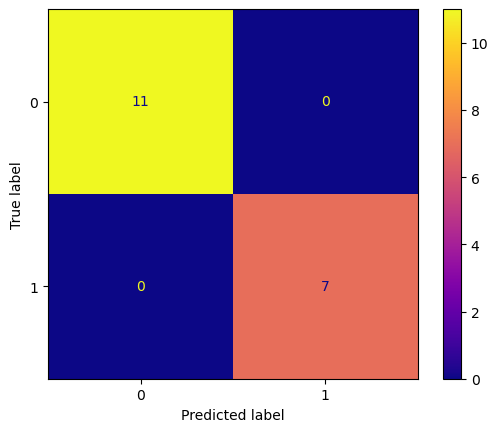

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix(Y_HOLDOUT_PREDS,Y_FINAL_HOLDOUT))
disp.plot(cmap=plt.cm.plasma)
plt.show()

In [68]:

print(f"precision: {precision_score(Y_HOLDOUT_PREDS,Y_FINAL_HOLDOUT)}\nrecall: {recall_score(Y_HOLDOUT_PREDS,Y_FINAL_HOLDOUT)}\nacc: {accuracy_score(Y_HOLDOUT_PREDS,Y_FINAL_HOLDOUT)}")

precision: 1.0
recall: 1.0
acc: 1.0
